In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import astropy.units as u

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare, id_segments, EasyE
from flarePipeline import vetFlare

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [2]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'

# Lots of flare detections towards the end
# Looks like the ones toward the beginning got missed
# This gets much better if we drop the CPA parameters to 3, 1, 3
f1 = 'tess2018206045859-s0001-0000000079403675-0120-s_lc.fits'

f2 = 'tess2019112060037-s0011-0000000121196226-0143-s_lc.fits'

f3 = 'tess2018206045859-s0001-0000000212262797-0120-s_lc.fits'

# Looks like a couple of strong flares are being missed?
# Its because I masked out this region of the LC
f4 = 'tess2018206045859-s0001-0000000266997586-0120-s_lc.fits'

# Lots of flares, why are some missed?
f5 = 'tess2018234235059-s0002-0000000102032397-0121-s_lc.fits'

# Looks like a big flare, but bad fit. Did the GP have trouble here?
f6 = 'tess2018349182459-s0006-0000000219423316-0126-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

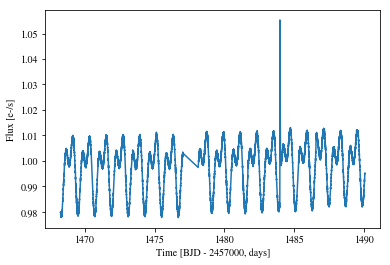

In [3]:
with fits.open(path+f6, mode='readonly') as hdulist:
    #print(hdulist[1].header)
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) & (~np.isnan(tess_bjds))

time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')
#plt.xlim(1624.8,1628)

In [4]:
acf = xo.autocorr_estimator(time, flux/median,
                        yerr=error/median,
                        min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    acf_1dt = (time[-1] - time[0])/2
    s_window = 128

In [5]:
acf_1dt

1.1978910703987822

11926 14811
11824 11926
11819 11824
11814 11819
11812 11814
11809 11812
11805 11809
11803 11805
11800 11803
11797 11800
11794 11797
11792 11794
11790 11792
11787 11790
11785 11787
11782 11785
11781 11782
11780 11781
11779 11780
11778 11779


(1483.75, 1484.25)

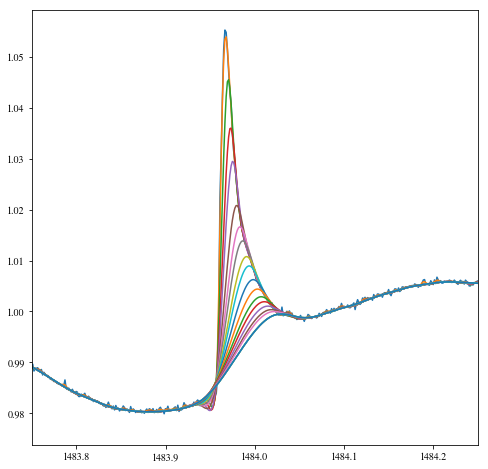

In [39]:
num_iter = 20

x = time
y = flux/median
yerr = error/median

# Here is the kernel we will use for the GP regression
# It consists of a sum of two stochastically driven damped harmonic
# oscillators. One of the terms has Q fixed at 1/sqrt(2), which
# forces it to be non-periodic. There is also a white noise term
# included.

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter('log_Q')

# A periodic component
Q = 1.0
w0 = 2*np.pi/acf_1dt
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# Now calculate the covariance matrix using the initial
# kernel parameters
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)

def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp,m ):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

# Find the best fit kernel parameters. We want to try to ignore the flares
# when we do the fit. To do this, we will repeatedly find the best fit
# solution to the kernel model, calculate the covariance matrix, predict
# the flux and then mask out points based on how far they deviate from
# the model. After a few passes, this should cause the model to fit mostly
# to periodic features.
m = np.ones(len(x), dtype=bool)
for i in range(num_iter):
    n_pts_prev = np.sum(m)
    gp.compute(x[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method='L-BFGS-B', bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
    initial_params = soln.x
    smo = gp.predict(y[m], x, return_cov=False, return_var=False)
    var = np.nanvar(y - smo)
    sig = np.sqrt(var)
    axes.plot(x, smo)

    m0 = y - smo < 0.8*sig
    m[m==1] = m0[m==1]
    n_pts = np.sum(m)
    print(n_pts, n_pts_prev)
    if n_pts <= 1000:
        raise ValueError('GP iteration threw out too many points')
        break
    if (n_pts == n_pts_prev):
        break

gp.compute(x[m], yerr[m])
smo = gp.predict(y[m], x, return_cov=False, return_var=False)
axes.set_xlim(1483.75, 1484.25)

(1483.75, 1484.25)

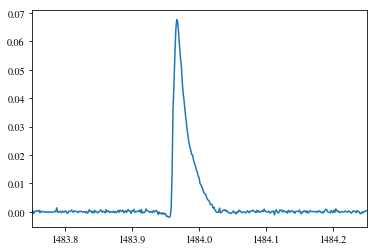

In [40]:
plt.plot(x, flux/median - smo)
plt.xlim(1483.75, 1484.25)

1483.9659005308715 0.012091617656023937 0.08434119609593616


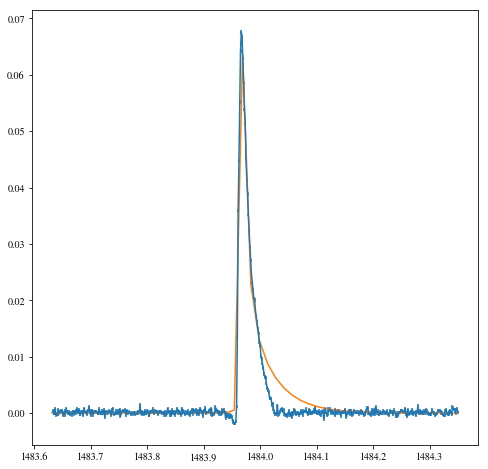

In [57]:
from flareFind import fitFlare
import flareHelpers as fh

x = time
y = flux/median - smo
yerr = error/median

# Search for flares in the smoothed light curve using change point analysis
FL = FINDflare(y, yerr, avg_std=True, std_window=s_window, N1=3, N2=1, N3=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    tstart, tstop = x[s1], x[s2]
    dx_fac  = 10
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    mask = (x > x1) & (x < x2)
    
    if (tstart < 1483.75) or (tstart > 1484.25):
        continue

    # Mask out other flare detections when fitting models
    other_mask = np.ones(len(x), dtype=bool)
    for i in range(len(FL[0])):
        s1other, s2other = FL[0][i], FL[1][i]+1
        if i == j:
            continue
        other_mask[s1other:s2other] = 0

    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq, skew, cover = \
        fitFlare(x[other_mask], y[other_mask], yerr[other_mask], x1, x2)

    mu, std, g_amp = popt1[0], popt1[1], popt1[2]
    mu_err, std_err, g_amp_err = pstd1[0], pstd1[1], pstd1[2]

    tpeak, fwhm, f_amp = popt2[0], popt2[1], popt2[2]
    tpeak_err, fwhm_err, f_amp_err = pstd2[0], pstd2[1], pstd2[2]
    
    fig, axes = plt.subplots(figsize=(8,8))
    axes.errorbar(time[mask], flux[mask]/median - smo[mask], error[mask]/median)
    
    xmodel = np.linspace(x1, x2)
    ymodel = fh.aflare1(xmodel, tpeak, fwhm, f_amp)
    print(tpeak, fwhm, f_amp)
    axes.plot(xmodel, ymodel)